## Imports

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Datasets

In [97]:
natality_df = pd.read_csv("datasets/natality/db.csv")

natality_df = natality_df[[
    "SPECIFICATION: Specification",  # Location
    "VARIABLE: Variable",  # Type
    "TIME_PERIOD: Time period",  # Year
    "OBS_VALUE",  # Value
]]

# Rename columns to make it easier to work with
natality_df.columns = ["location", "type", "year", "value"]

type_to_short_name = {
    "A01: Live births by municipality of residence": "Live births",
    "A02: Deaths by municipality of residence": "Deaths",
    "A03: Natural balance by municipality of residence": "Natural balance",
}

natality_df["type"] = natality_df["type"].map(type_to_short_name)
natality_df["value"] = natality_df["value"].fillna(0)

In [98]:
migration_df = pd.read_csv("datasets/migration/db.csv")

migration_df = migration_df[[
    "SPECIFICATION: Specification",  # Location
    "POP_MOVEMENT: Population Movement",  # Type
    "TIME_PERIOD: Time period",  # Year
    "OBS_VALUE",  # Value
]]

# Rename columns to make it easier to work with
migration_df.columns = ["location", "type", "year", "value"]
migration_df["value"] = migration_df["value"].fillna(0)


In [99]:
prices_df = pd.read_csv("datasets/house_prices/csv/prices.csv")
totals_df = pd.read_csv("datasets/house_prices/csv/totals.csv")

# There's 1 row with a NaN value in the prices_df dataframe
prices_df = prices_df.fillna("*")

# Plot the total houses sold per year
totals_df["Total Houses Sold"] = totals_df["Total Finished Houses Sold"] + totals_df["Total Unfinished Houses Sold"]
totals_df["Total Average Price"] = (totals_df["National Average Price per m^2 of Finished Houses"] +
                                    totals_df["National Average Price per m^2 of Unfinished Houses"]) / 2

convert_range = lambda x: x.replace(" ", "").replace("€", "").split("-")

totals_df["National Average Range of Price per m^2 of Finished Houses"] = totals_df[
    "National Average Range of Price per m^2 of Finished Houses"].map(convert_range)
totals_df["National Average Range of Price per m^2 of Unfinished Houses"] = totals_df[
    "National Average Range of Price per m^2 of Unfinished Houses"].map(convert_range)

for i, row in enumerate(prices_df["m^2 price range"]):
    prices_df.at[i, "m^2 price range"] = convert_range(row) if row != "*" else "*"

for i, row in enumerate(prices_df["Unfinished Houses m^2 price range"]):
    prices_df.at[i, "Unfinished Houses m^2 price range"] = convert_range(row) if row != "*" else "*"


Joining the migration data with the natural movement data.

In [100]:
# We want to join the dataframes on the location and year columns
population_df = migration_df.copy()
# Drop all rows with years that are smaller than 1990
population_df = population_df[population_df["year"] >= 1990]

for i, row in natality_df.iterrows():
    if row["type"] == "Live births":
        # Add to the M001: Arrivals column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M001: Arrivals"), "value"] += row["value"]
    elif row["type"] == "Deaths":
        # Add to the M002: Departures column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M002: Departures"), "value"] += row["value"]
    elif row["type"] == "Natural balance":
        # Add to the M003: Net migration column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M003: Net migration"), "value"] += row["value"]

population_df["type"] = population_df["type"].map({
    "M001: Arrivals": "Increase",
    "M002: Departures": "Decrease",
    "M003: Net migration": "Balance"
})

population_df.head()


,location,type,year,value
0,CM10008: Mondercange,Increase,1990,434.0
1,CM10008: Mondercange,Increase,1991,552.0
2,CM10008: Mondercange,Increase,1992,618.0
3,CM10008: Mondercange,Increase,1993,560.0
4,CM10008: Mondercange,Increase,1994,528.0


## Analysis

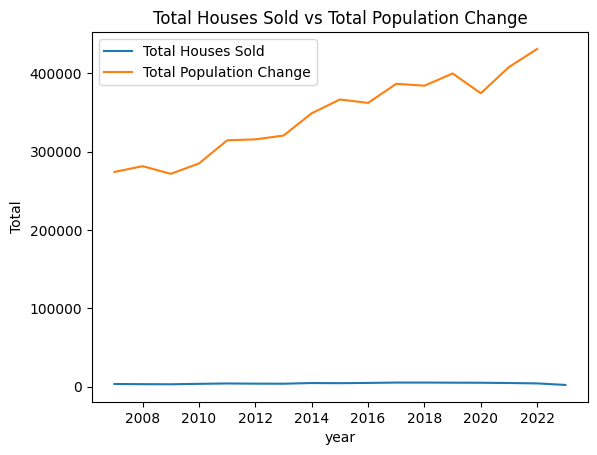

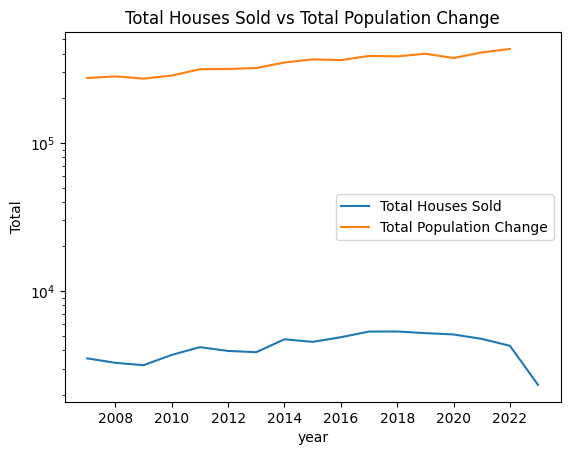

In [107]:
# Plot the total houses sold per year vs the total population change per year from 2007 onwards
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Houses Sold", ax=ax, label="Total Houses Sold")
population_df_ = population_df[population_df["year"] >= 2007].copy()
population_df_ = population_df_.groupby("year").sum()
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total")
plt.title("Total Houses Sold vs Total Population Change")
plt.show()

# Now with a log scale
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Houses Sold", ax=ax, label="Total Houses Sold")
population_df_ = population_df[population_df["year"] >= 2007].copy()
population_df_ = population_df_.groupby("year").sum()
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total")
plt.yscale("log")
plt.title("Total Houses Sold vs Total Population Change")
plt.show()


We can see that despite the huge population increase, the number of sold houses hasn't changed much.

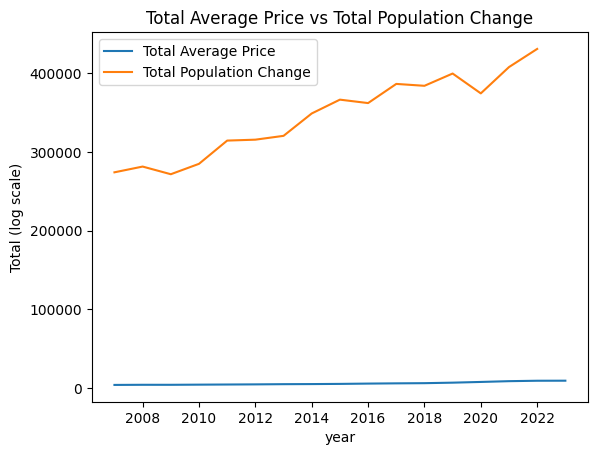

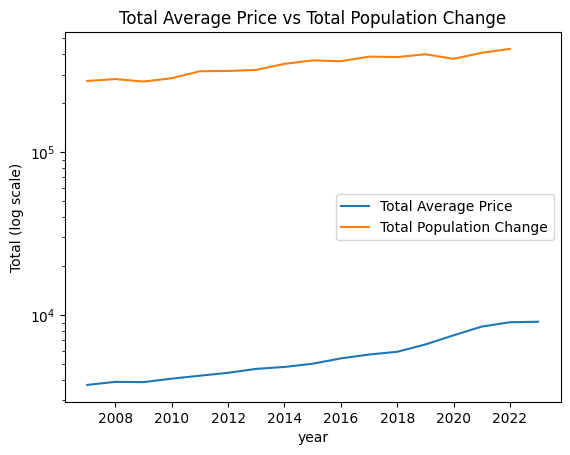

In [106]:
# Plot the house prices per year vs the total population change per year from 2007 onwards
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Average Price", ax=ax, label="Total Average Price")
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total (log scale)")
plt.title("Total Average Price vs Total Population Change")
# Change the y-axis to a logarithmic scale
plt.show()

fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Average Price", ax=ax, label="Total Average Price")
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total (log scale)")
plt.title("Total Average Price vs Total Population Change")
# Change the y-axis to a logarithmic scale
plt.yscale("log")
plt.show()


It's easier to see the changes with the log scale.

In [110]:
# Correlation between the total houses sold and the total population change
correlation = totals_df["Total Houses Sold"].corr(population_df[population_df["year"] >= 2007]["value"])
print(f"Correlation between the total houses sold and the total population change: {correlation}")

Correlation between the total houses sold and the total population change: nan
